# Predict on all merged data

In [6]:
import pandas as pd
import os 
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import autosklearn.regression
from tpot import TPOTRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.metrics import mean_squared_error


from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters



os.chdir("/home/cernerrood246/University/DataMining")

#Relevant Models: LR, SVM, LightGBM, CatBoost, XGBoost 

## Feature engineering

In [37]:
participants_list = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17'] 

Merged_all_list = []
for participant in participants_list:
    df = pd.read_pickle(f"merged_dataset/{participant}/ALL.pkl")
    df['Participant'] = participant
    Merged_all_list.append(df)

feature_Merged_all_list = []
for participant_temp in Merged_all_list:
    participant = participant_temp.copy()
    #add lag features
    participant.rename(columns={"value__bpm": "valuebpm", "value__confidence" : "valueconfidence"}, inplace=True)
    relevant_columns = ["valuebpm", "valueconfidence", "X", "Y", "Z", "Magnitude"]
    X_columns = relevant_columns.copy()
    X_columns.extend(['Activity','BMI', 'Fat', 'Muscle',
       'Water', 'Bone', 'Weight', 'Height', 'Age', 'Gender_F', 'Gender_M'])
    #fill missing values 
    participant.ffill(inplace=True)
    participant.bfill(inplace=True)

    extract_features_colums = relevant_columns.copy()
    extract_features_colums.extend(['Time[s]'])

    for column in relevant_columns:
        for i in range(1, 10, 2):
            participant[f"{column}_lag_{i}"] = participant[column].shift(i)
            X_columns.append(f"{column}_lag_{i}")
            participant.bfill(inplace=True)
            participant.ffill(inplace=True)

    participant_features = extract_features(participant[extract_features_colums].copy(), column_id='Time[s]',
                    # we impute = remove all NaN features automatically,
                    default_fc_parameters = MinimalFCParameters(),
                    n_jobs = 4,
                    #impute_function=impute
                    )
    
    # merge participant_features with participant 
    participant = participant.merge(participant_features, left_on='Time[s]', right_index=True)
    feature_Merged_all_list.append(participant)

X_columns.extend(participant_features.columns) 
    

Feature Extraction: 100%|██████████| 20/20 [00:08<00:00,  2.50it/s]


## Add Features

Possible: 
-Time[s]
-Lag feature for every value
-activity
-demographics 

Timeseries prediction 
-classify activity?

## All Data without timestamp

In [38]:
n_splits = 17

parameters_4_50 = dict([('colsample_bytree', 0.6174372236293935),
             ('learning_rate', 0.03335590817699578),
             ('max_depth', 3),
             ('min_child_weight', 2.8157820836606042),
             ('subsample', 0.5)])

parameters_17_100 = dict([('colsample_bytree', 0.6771669106036801),
             ('learning_rate', 0.044101899680420484),
             ('max_depth', 3),
             ('min_child_weight', 0.5),
             ('subsample', 0.3)])

parameters_17_50 = dict([('colsample_bytree', 0.8293768713559813),
             ('learning_rate', 0.07734816836241316),
             ('max_depth', 3),
             ('min_child_weight', 0.5),
             ('subsample', 0.3)])

parameters = parameters_4_50
all_merged_df = pd.concat(feature_Merged_all_list, axis=0)

#all_merged_df = all_merged_df.dropna() # drops roughly 6k atm
print(len(all_merged_df))

all_merged_df_selected = all_merged_df[X_columns].copy()
# all_merged_df_selected = select_features(all_merged_df[X_columns], all_merged_df["MET"])

X = all_merged_df_selected.to_numpy()
y = all_merged_df["MET"].to_numpy()

# Get the list of participants
participants = all_merged_df['Participant']

# Initialize the GroupKFold object
group_kfold = GroupKFold(n_splits=n_splits)
model = XGBRegressor(**parameters)

scaler = MinMaxScaler()
X = scaler.fit_transform(X)


27656


In [11]:
# Perform cross-validation and calculate mean squared error
scores = cross_val_score(model, X, y, groups=participants, cv=group_kfold, scoring='neg_mean_squared_error', n_jobs=-1)
print("Cross-validation scores:", -scores)
mse = -scores.mean()

print("Mean squared error:", mse)

Cross-validation scores: [2.35398699 0.72944009 0.93342113 1.11824923 3.80115033 1.51090144
 0.83678374 1.78655587 5.01608584 1.73008346 1.27780142 3.09453215
 1.69257248 4.94232313 0.99630667 2.08376074 0.10829782]
Mean squared error: 2.000720737821607


In [ ]:
scores

In [4]:
for i,group in enumerate(group_kfold.split(X, y, participants)):
    print(f"Fold {i}")
    print(f"Train size: {group[0].size}")
    print(f"Test size: {group[1].size}")
    print(f"Train participants: {participants.iloc[group[0]].unique()}")
    print(f"Test participants: {participants.iloc[group[1]].unique()}")

Fold 0
Train size: 25630
Test size: 2026
Train participants: ['P1' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P2']
Fold 1
Train size: 25836
Test size: 1820
Train participants: ['P1' 'P2' 'P3' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P4']
Fold 2
Train size: 25854
Test size: 1802
Train participants: ['P2' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P1']
Fold 3
Train size: 25854
Test size: 1802
Train participants: ['P1' 'P2' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P13']
Fold 4
Train size: 25855
Test size: 1801
Train participants: ['P1' 'P2' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13'
 'P14' 'P15' 'P16']
Test participants: ['P17']
Fold 5
Train size: 25860
Test size: 1796
Train participants: ['P1' 'P2' 'P3' 'P4' 'P5' 'P6' 'P8' 'P9' 'P10' 'P

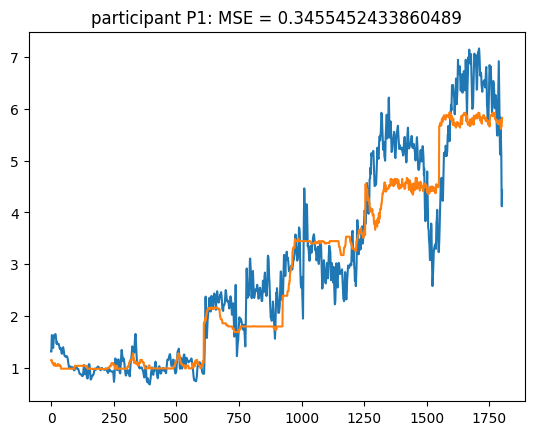

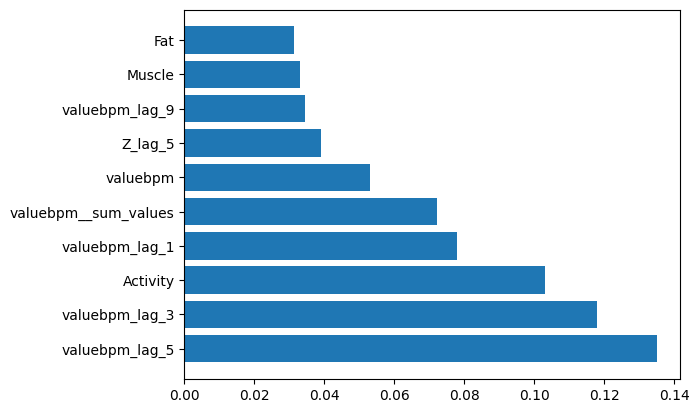

mean MET: true = 2.965399624717587 predicted = 2.8117353916168213, mse =0.023612696534446496


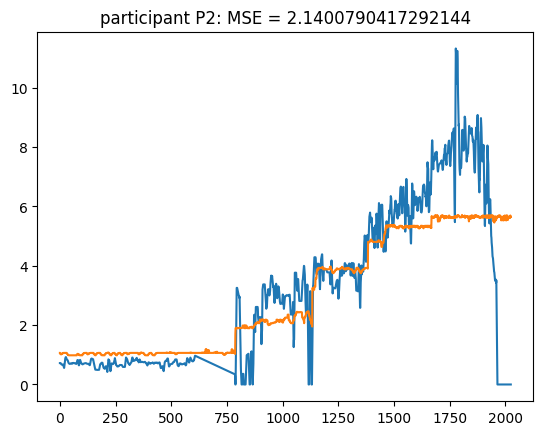

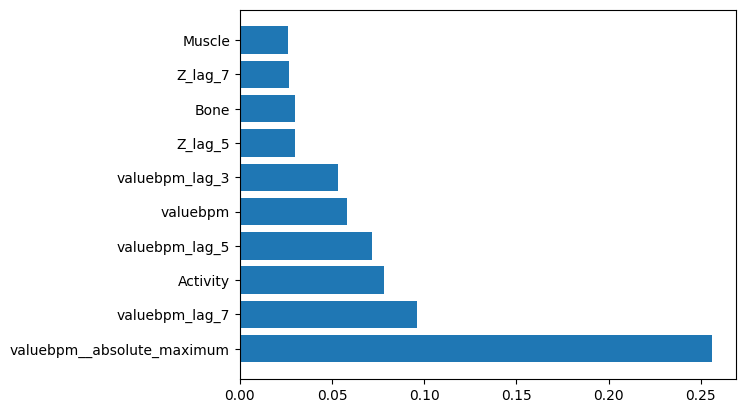

mean MET: true = 3.0429846431393215 predicted = 2.9655845165252686, mse =0.005990779599871425


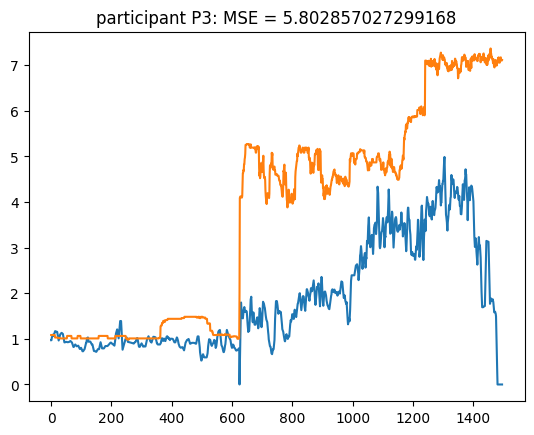

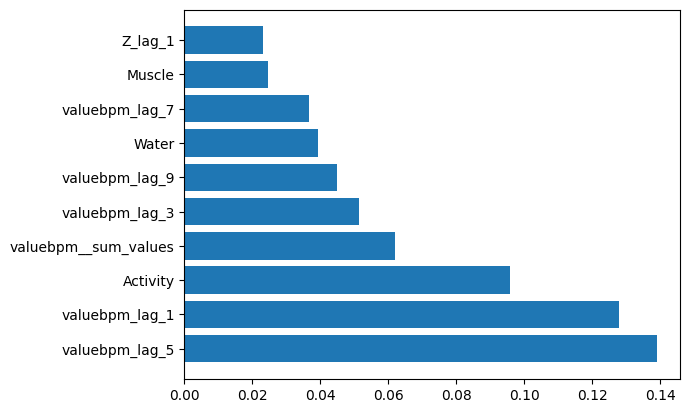

mean MET: true = 1.8743836065766502 predicted = 3.6844229698181152, mse =3.2762424964835684


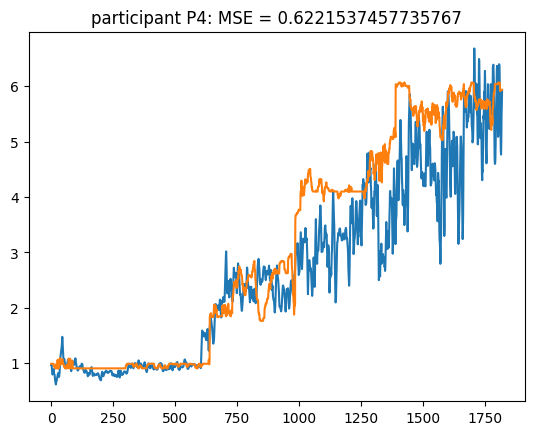

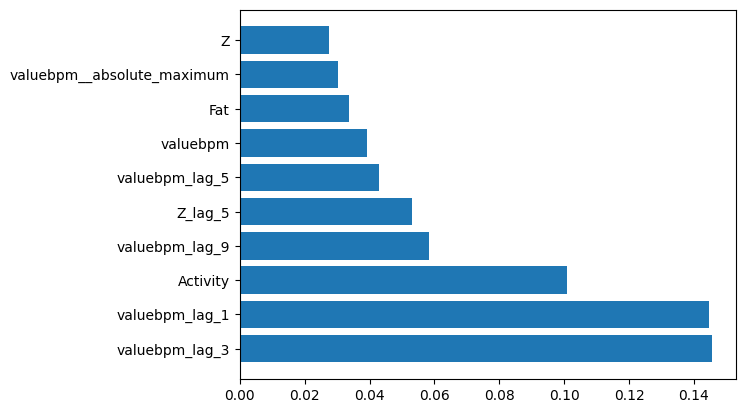

mean MET: true = 2.659827527324808 predicted = 3.0735671520233154, mse =0.1711804770456616


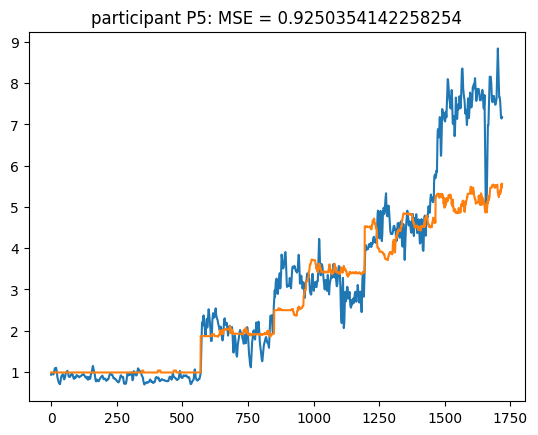

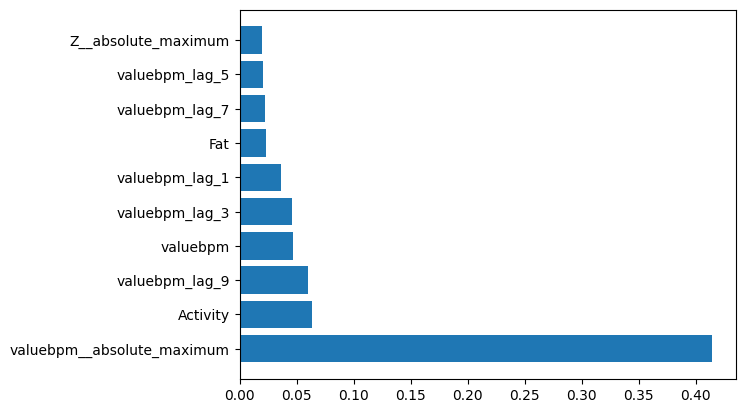

mean MET: true = 3.0410911026147316 predicted = 2.7301080226898193, mse =0.09671047599958436


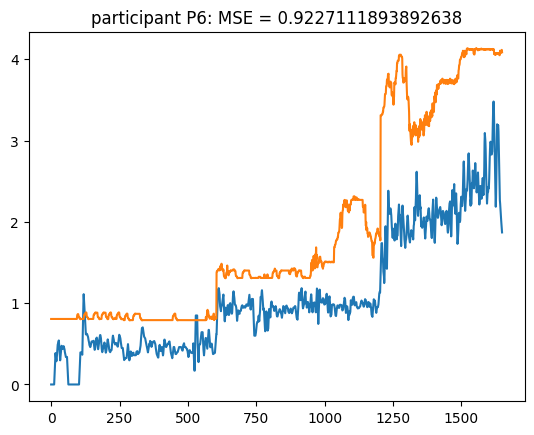

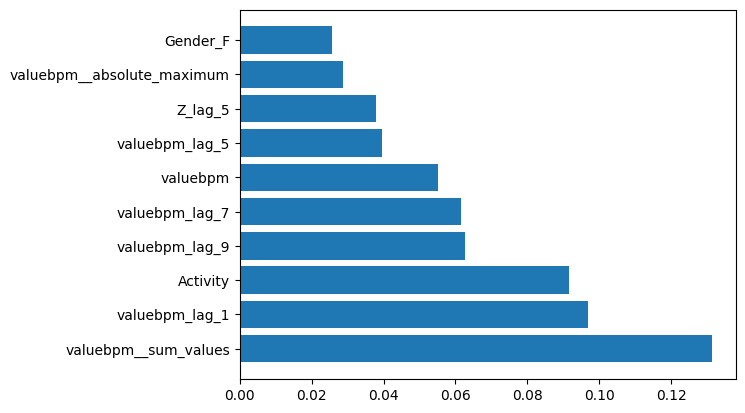

mean MET: true = 1.0911265431754757 predicted = 1.8765102624893188, mse =0.6168275865632454


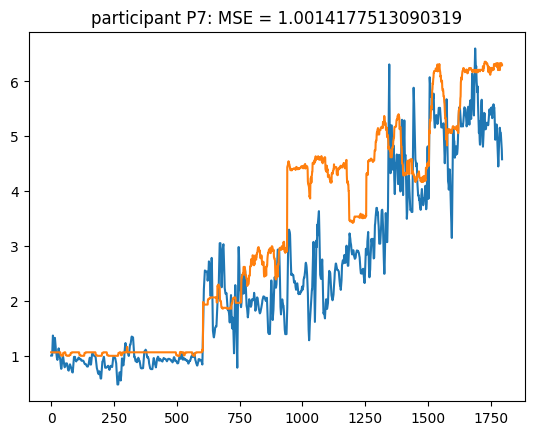

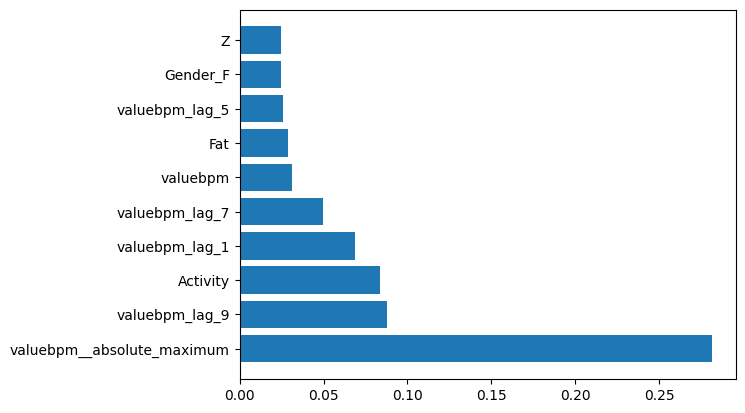

mean MET: true = 2.5248162547852937 predicted = 3.1499218940734863, mse =0.3907570602699


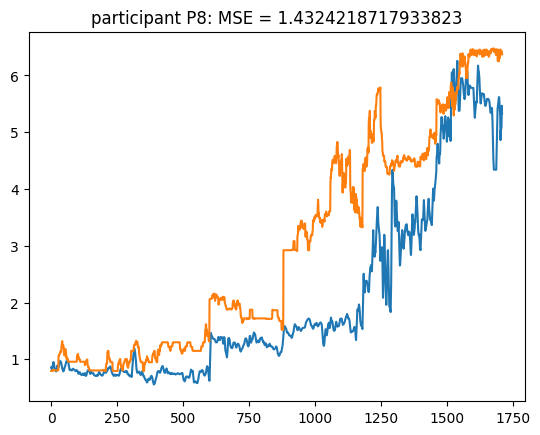

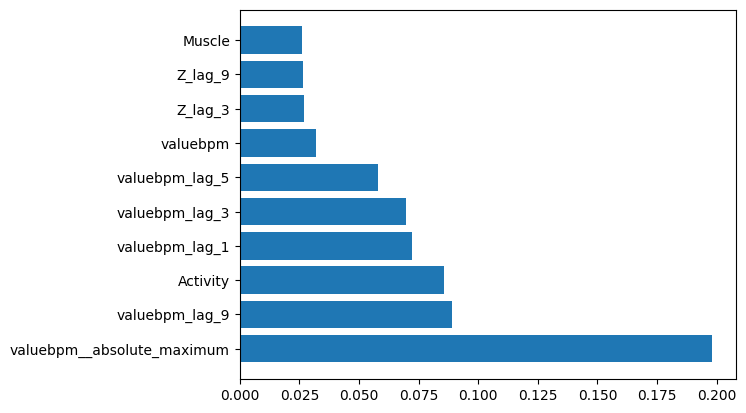

mean MET: true = 2.0575034762077444 predicted = 2.9576878547668457, mse =0.8103319154018354


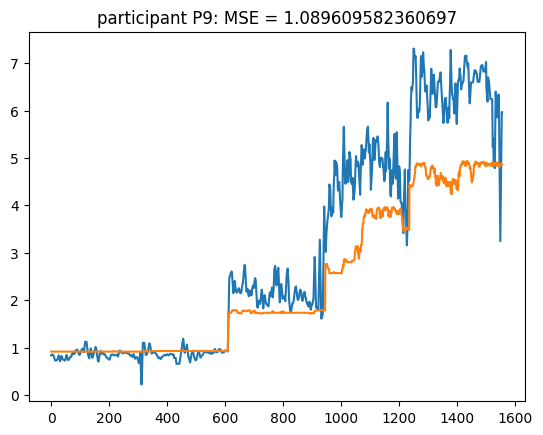

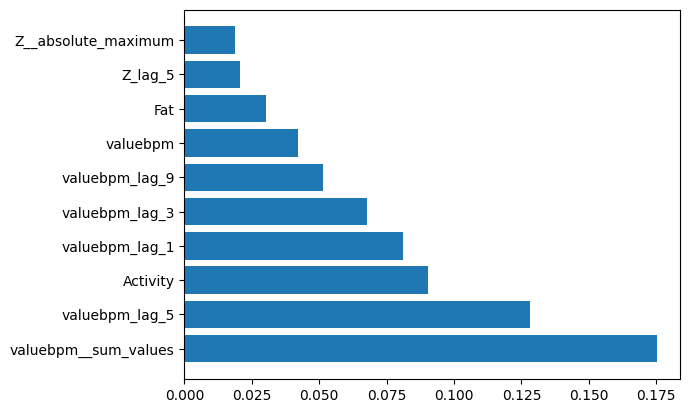

mean MET: true = 2.9857805508248747 predicted = 2.3305413722991943, mse =0.42933838107500844


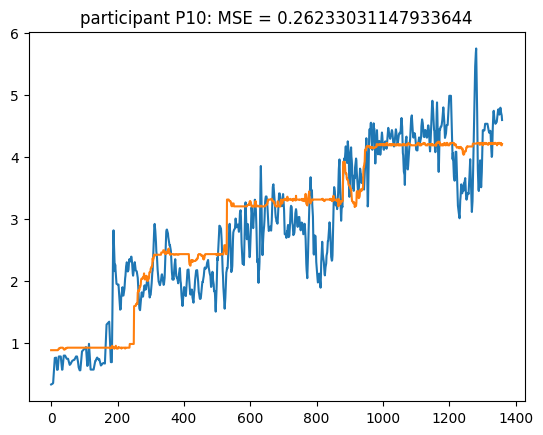

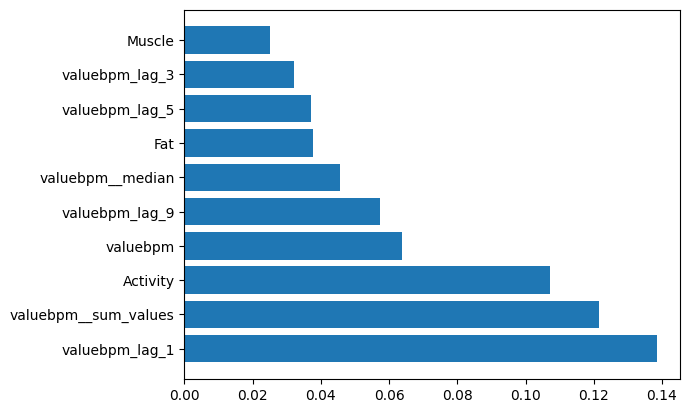

mean MET: true = 2.8312401419716986 predicted = 2.934962511062622, mse =0.010758329849833756


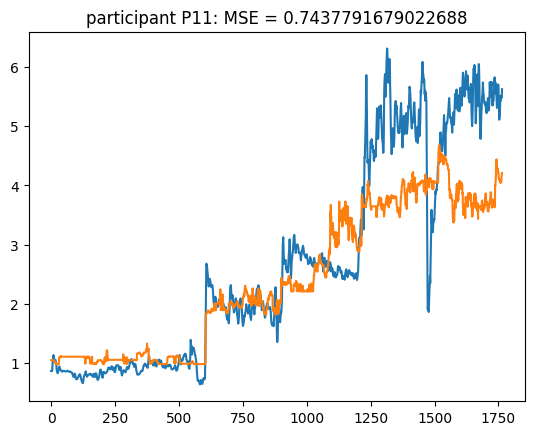

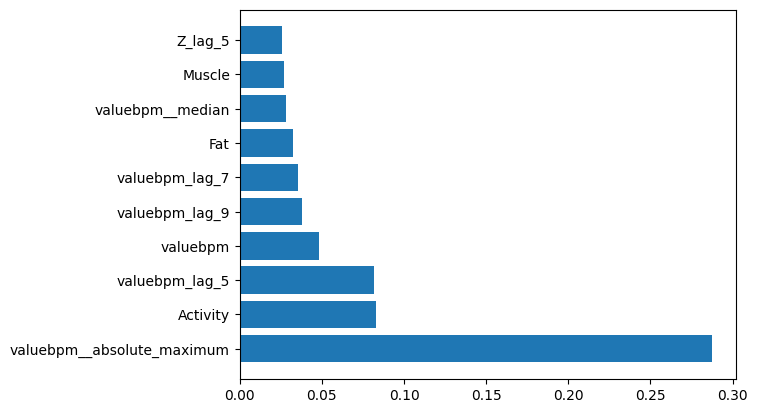

mean MET: true = 2.691007514268926 predicted = 2.3854992389678955, mse =0.09333530627741025


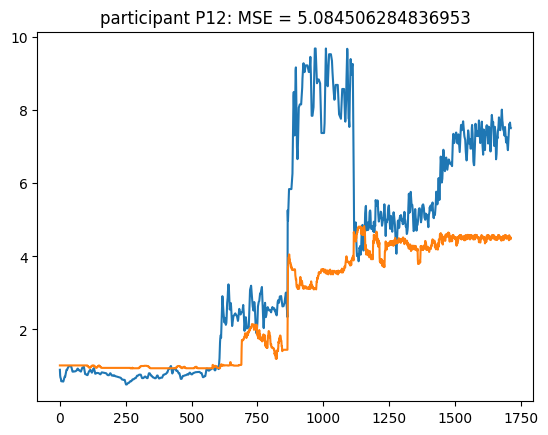

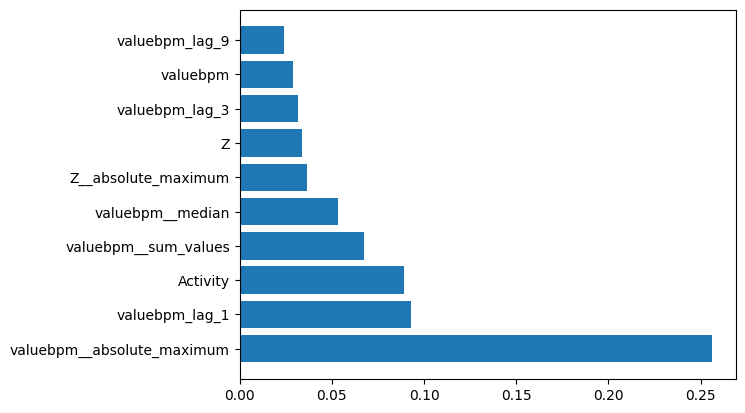

mean MET: true = 3.9616551753895375 predicted = 2.6141531467437744, mse =1.815761717204447


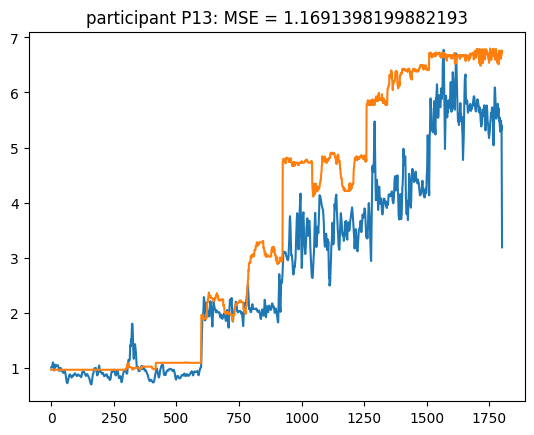

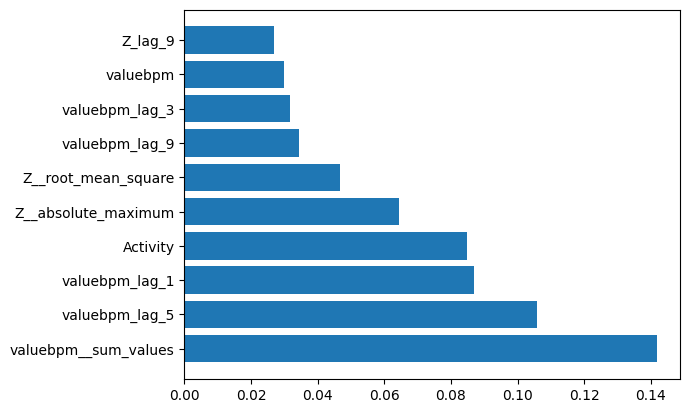

mean MET: true = 2.814999325167751 predicted = 3.59623646736145, mse =0.6103314723429779


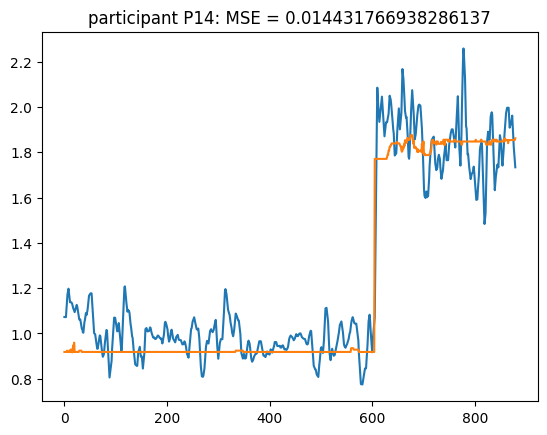

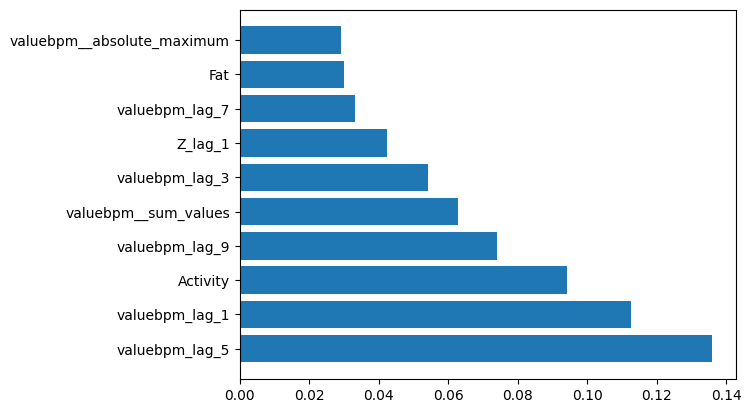

mean MET: true = 1.2521494472261814 predicted = 1.204940676689148, mse =0.0022286680156182754


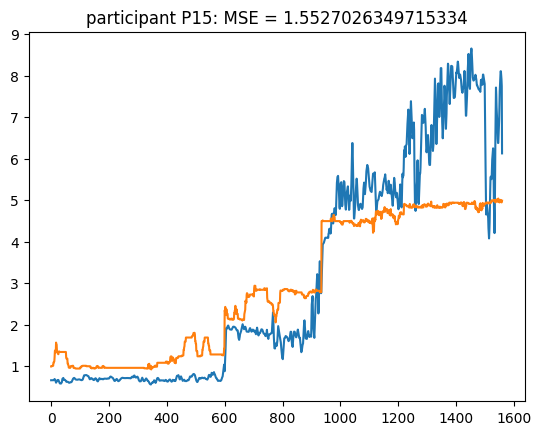

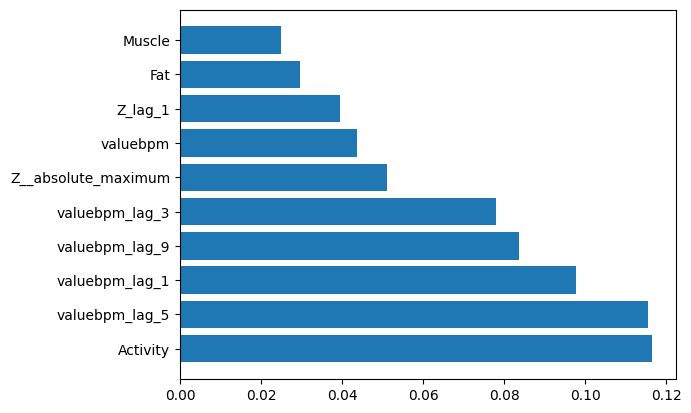

mean MET: true = 3.107075894050837 predicted = 2.8924248218536377, mse =0.04607508279540725


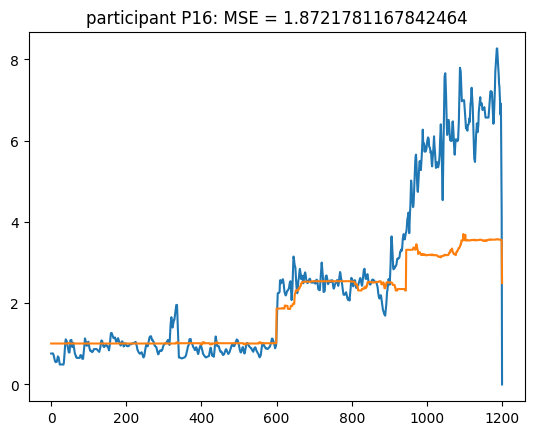

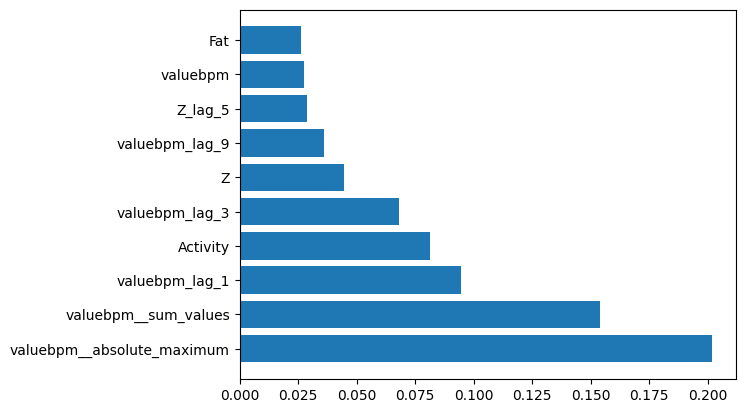

mean MET: true = 2.4935408381968642 predicted = 1.9125515222549438, mse =0.3375485852386606


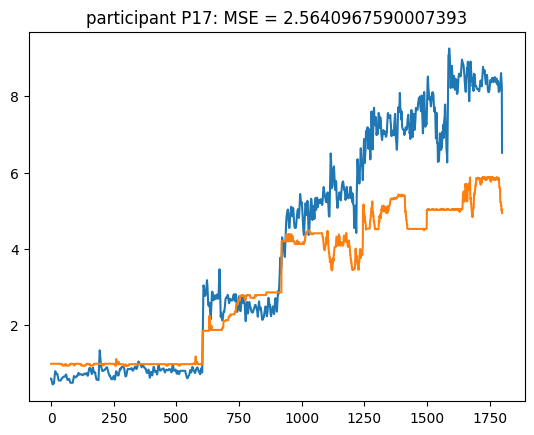

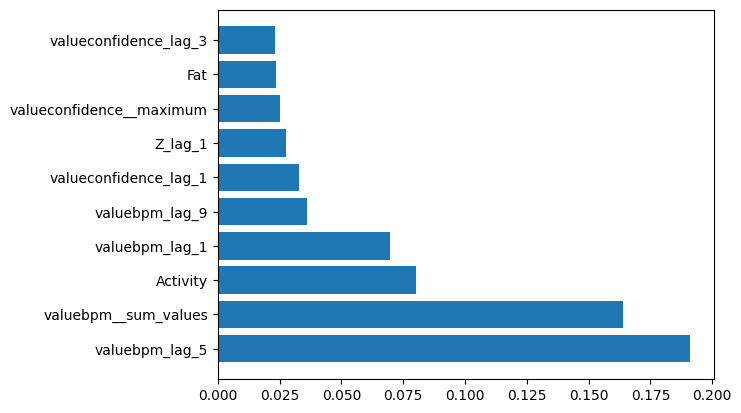

mean MET: true = 4.0317177435362535 predicted = 3.084444761276245, mse =0.8973261029197701


In [39]:
X_train_all = []
X_test_all = []
y_train_all = []
y_test_all = []
participants_all = []

mse_participants = []

for i,group in enumerate(group_kfold.split(X, y, participants)):
    X_train, X_test = X[group[0]], X[group[1]]
    y_train, y_test = y[group[0]], y[group[1]]
    participant = participants.iloc[group[1]].unique()[0]

    X_train_all.append(X_train)
    X_test_all.append(X_test)
    y_train_all.append(y_train)
    y_test_all.append(y_test)
    participants_all.append(participant)

for participant in participants_list:
    index = participants_all.index(participant)
    X_train = X_train_all[index]
    X_test = X_test_all[index]
    y_train = y_train_all[index]
    y_test = y_test_all[index]
    
    model = XGBRegressor(**parameters)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    #plot both y_test and y_pred
    plt.plot(y_test)
    plt.plot(y_pred)
    plt.title(f"participant {participant}: MSE = {mse}")
    plt.show()

    n_top_features = 10
    sorted_idx = model.feature_importances_.argsort()[::-1]
    plt.barh(all_merged_df_selected.columns[sorted_idx][:n_top_features], model.feature_importances_[sorted_idx][:n_top_features ])
    plt.show()

    print(f"mean MET: true = {y_test.mean()} predicted = {y_pred.mean()}, mse ={mean_squared_error([y_test.mean()],[y_pred.mean()])}")
    mse_participants.append(mse)
    



<BarContainer object of 10 artists>

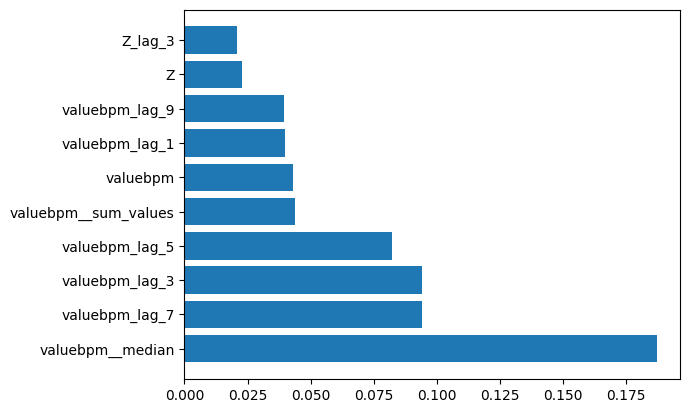

In [35]:
n_top_features = 10
sorted_idx = model.feature_importances_.argsort()[::-1]
plt.barh(all_merged_df_selected.columns[sorted_idx][:n_top_features], model.feature_importances_[sorted_idx][:n_top_features ])

In [26]:
list(all_merged_df_selected.columns)[sorted_idx[:n_top_features]],

TypeError: only integer scalar arrays can be converted to a scalar index

In [29]:
list(all_merged_df_selected.columns)[sorted_idx[:n_top_features]]

TypeError: only integer scalar arrays can be converted to a scalar index

In [34]:
all_merged_df_selected.columns[sorted_idx[:n_top_features]]

Index(['valuebpm__median', 'valuebpm_lag_7', 'valuebpm_lag_3',
       'valuebpm_lag_5', 'valuebpm__sum_values', 'valuebpm', 'valuebpm_lag_1',
       'valuebpm_lag_9', 'Z', 'Z_lag_3'],
      dtype='object')

In [17]:
#correlate with demographics 

demographics = pd.read_pickle("preprocessed_dataset/demographics.pkl")
demographics["mse"] = mse_participants

demographics.corr()["mse"]

BMI        -0.350786
Fat        -0.426149
Muscle      0.667777
Water       0.686290
Bone        0.862132
Weight     -0.183790
Height      0.208244
Age        -0.182982
Gender_F   -0.129826
Gender_M    0.129826
mse         1.000000
Name: mse, dtype: float64

In [18]:
demographics

,BMI,Fat,Muscle,Water,Bone,Weight,Height,Age,Gender_F,Gender_M,mse
0,24.7,33,14,49,4,70.6,166,29,1,0,0.933421
1,25.7,20,15,54,4,77.0,173,26,0,1,2.353987
2,20.6,23,16,57,5,61.0,172,26,1,0,4.942323
3,26.6,17,15,53,4,81.5,175,27,0,1,0.729440
4,24.8,31,14,48,4,66.0,163,33,1,0,1.786556
5,30.8,32,14,50,4,99.7,180,40,0,1,1.277801
6,25.8,18,14,50,4,71.0,166,34,0,1,1.510901
7,26.4,22,14,48,4,85.6,180,33,0,1,1.730083
8,26.4,19,14,49,4,76.0,177,27,0,1,1.692572
9,27.8,24,14,51,4,87.0,177,41,0,1,0.996307


array([[0.33421751, 0.33333333, 0.60103627, ..., 0.53865526, 0.53865526,
        0.53865526],
       [0.33421751, 0.33333333, 0.60103627, ..., 0.53931086, 0.53931086,
        0.53931086],
       [0.33421751, 0.33333333, 0.60103627, ..., 0.53970433, 0.53970433,
        0.53970433],
       ...,
       [0.91114058, 0.66666667, 0.75129534, ..., 0.50540478, 0.50540478,
        0.50540478],
       [0.91114058, 0.66666667, 0.61139896, ..., 0.29352312, 0.29352312,
        0.29352312],
       [0.91114058, 0.66666667, 0.6746114 , ..., 0.38233449, 0.38233449,
        0.38233449]])

In [42]:

#parameters chosen from https://datascience.stackexchange.com/questions/108233/recommendations-for-tuning-xgboost-hyperparams
#https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html#skopt.BayesSearchCV

group_kfold = GroupKFold(n_splits=n_splits)

opt = BayesSearchCV(
    XGBRegressor(),
    {
        'max_depth': Integer(3, 7),
        'min_child_weight': Real(0.5, 5),
        'subsample': Real(0.3, 1),
        'colsample_bytree': Real(0.01, 1),
        'learning_rate':Real(0.01, 1),
    },
    n_iter=50,
    cv=group_kfold.get_n_splits(X, y, participants),
    scoring = 'neg_mean_squared_error',
    verbose = 2,
    n_jobs=-1

)

opt.fit(X, y)

print("val. score: %s" % opt.best_score_)

Fitting 17 folds for each of 1 candidates, totalling 17 fits
[CV] END colsample_bytree=0.3814640565671857, learning_rate=0.9072054702286829, max_depth=6, min_child_weight=2.6469027873255007, subsample=0.3534409563875219; total time=   8.0s
[CV] END colsample_bytree=0.3814640565671857, learning_rate=0.9072054702286829, max_depth=6, min_child_weight=2.6469027873255007, subsample=0.3534409563875219; total time=   8.1s
[CV] END colsample_bytree=0.3814640565671857, learning_rate=0.9072054702286829, max_depth=6, min_child_weight=2.6469027873255007, subsample=0.3534409563875219; total time=   8.3s
[CV] END colsample_bytree=0.3814640565671857, learning_rate=0.9072054702286829, max_depth=6, min_child_weight=2.6469027873255007, subsample=0.3534409563875219; total time=   9.2s
[CV] END colsample_bytree=0.3814640565671857, learning_rate=0.9072054702286829, max_depth=6, min_child_weight=2.6469027873255007, subsample=0.3534409563875219; total time=   4.5s
[CV] END colsample_bytree=0.3814640565671857

/home/cernerrood246/anaconda3/envs/DM_3.9/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.530499474637693, learning_rate=0.1749044390416933, max_depth=7, min_child_weight=3.635452276680462, subsample=0.6691969919469285; total time=   6.4s
[CV] END colsample_bytree=0.530499474637693, learning_rate=0.1749044390416933, max_depth=7, min_child_weight=3.635452276680462, subsample=0.6691969919469285; total time=   6.6s
[CV] END colsample_bytree=0.530499474637693, learning_rate=0.1749044390416933, max_depth=7, min_child_weight=3.635452276680462, subsample=0.6691969919469285; total time=   6.7s
[CV] END colsample_bytree=0.530499474637693, learning_rate=0.1749044390416933, max_depth=7, min_child_weight=3.635452276680462, subsample=0.6691969919469285; total time=   6.7s
[CV] END colsample_bytree=0.530499474637693, learning_rate=0.1749044390416933, max_depth=7, min_child_weight=3.635452276680462, subsample=0.6691969919469285; total time=   6.6s
[CV] END colsample_bytree=0.530499474637693, learning_rate=0.1749044390416933, max_depth=7, min_child_weight=3.6354

/home/cernerrood246/anaconda3/envs/DM_3.9/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.6195110125467316, learning_rate=0.17108848482341743, max_depth=7, min_child_weight=3.6316120045718376, subsample=0.6200148142256723; total time=   6.7s
[CV] END colsample_bytree=0.6195110125467316, learning_rate=0.17108848482341743, max_depth=7, min_child_weight=3.6316120045718376, subsample=0.6200148142256723; total time=   6.7s
[CV] END colsample_bytree=0.6195110125467316, learning_rate=0.17108848482341743, max_depth=7, min_child_weight=3.6316120045718376, subsample=0.6200148142256723; total time=   6.7s
[CV] END colsample_bytree=0.6195110125467316, learning_rate=0.17108848482341743, max_depth=7, min_child_weight=3.6316120045718376, subsample=0.6200148142256723; total time=   7.3s
[CV] END colsample_bytree=0.6195110125467316, learning_rate=0.17108848482341743, max_depth=7, min_child_weight=3.6316120045718376, subsample=0.6200148142256723; total time=   7.2s
[CV] END colsample_bytree=0.6195110125467316, learning_rate=0.17108848482341743, max_depth=7, min_ch

/home/cernerrood246/anaconda3/envs/DM_3.9/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.3751075645262691, learning_rate=0.2042748725153538, max_depth=7, min_child_weight=0.5, subsample=0.3; total time=   6.1s
[CV] END colsample_bytree=0.3751075645262691, learning_rate=0.2042748725153538, max_depth=7, min_child_weight=0.5, subsample=0.3; total time=   6.2s
[CV] END colsample_bytree=0.3751075645262691, learning_rate=0.2042748725153538, max_depth=7, min_child_weight=0.5, subsample=0.3; total time=   6.3s
[CV] END colsample_bytree=0.3751075645262691, learning_rate=0.2042748725153538, max_depth=7, min_child_weight=0.5, subsample=0.3; total time=   6.6s
[CV] END colsample_bytree=0.3751075645262691, learning_rate=0.2042748725153538, max_depth=7, min_child_weight=0.5, subsample=0.3; total time=   6.4s
[CV] END colsample_bytree=0.3751075645262691, learning_rate=0.2042748725153538, max_depth=7, min_child_weight=0.5, subsample=0.3; total time=   6.5s
[CV] END colsample_bytree=0.3751075645262691, learning_rate=0.2042748725153538, max_depth=7, min_child_wei

In [46]:
opt.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8293768713559813, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.07734816836241316, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=0.5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Archive

In [18]:
# List of models to evaluate, set LGMB to not output info

models = [XGBRegressor()] #LinearRegression(), SVR(), LGBMRegressor(verbose=-1), CatBoostRegressor(verbose=0),
names = ["XGBoost"] #"Linear Regression", "Support Vector Machine", "LightGBM", "CatBoost", 
models_tuned = dict()

# Perform operations for each model
for model,name in zip(models, names):
    model.fit(X_train_scaled, y_train)
    
    # Predict on test data
    y_pred = model.predict(X_test_scaled)
    
    # Calculate mean squared error
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} Mean Squared Error: {mse}")
    models_tuned[name] = model


XGBoost Mean Squared Error: 0.11158988484317221


In [55]:
participant = "P3"

X_train, X_test, y_train, y_test = all_merged_df[all_merged_df["Participant"] != participant][X_columns].to_numpy(), all_merged_df[all_merged_df["Participant"] == participant][X_columns].to_numpy(), all_merged_df[all_merged_df["Participant"] != participant]["MET"].to_numpy(), all_merged_df[all_merged_df["Participant"] == participant]["MET"].to_numpy()
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = XGBRegressor()
model.fit(X_train_scaled, y_train)
    
# Predict on test data
y_pred = model.predict(X_test_scaled)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"{name} Mean Squared Error: {mse}")


XGBoost Mean Squared Error: 3.676475017709935


In [58]:
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=120,
    per_run_time_limit=30,
)
# Fit the AutoSklearnRegressor
automl.fit(X_train_scaled, y_train)

# Get the predicted values
y_pred = automl.predict(X_test_scaled)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"AutoSklearn Mean Squared Error: {mse}")

[WARNING] [2024-03-20 11:28:39,409:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-03-20 11:28:43,585:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-03-20 11:28:46,068:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-03-20 11:28:48,422:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-03-20 11:28:51,000:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-03-20 11:28:53,995:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-03-20 11:28:56,803:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-03-20 11:29:00,038:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-03-20 11:29:01,806:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-03-20 11:29:

In [97]:
# Define the TPOTRegressor
tpot = TPOTRegressor(generations=3, population_size=10, verbosity=2, random_state=42, cv = group_kfold.get_n_splits(X, y, participants))

# Fit the TPOTRegressor
tpot.fit(X, y)

# # Get the predicted values
# y_pred = tpot.predict(X_test_scaled)

# # Calculate the mean squared error
# mse = mean_squared_error(y_test, y_pred)
# print(f"TPOT Mean Squared Error: {mse}")


                                                                              
Generation 1 - Current best internal CV score: -2.274544481594872
                                                                            
Generation 2 - Current best internal CV score: -2.2734384906592924
                                                                            
Generation 3 - Current best internal CV score: -2.2656305712578018
                                                                            
Best pipeline: RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.05, min_samples_leaf=7, min_samples_split=16, n_estimators=100)


TPOTRegressor(cv=4, generations=3, population_size=10, random_state=42,
              verbosity=2)